# <h1 align= 'center'>Gensim Word2Vec Embeddings</h1>

The goal for this analysis is to predict if a review rates the movie positively or negatively. 
<a href="https://imgur.com/FfdEBRz"><img src="https://i.imgur.com/FfdEBRzm.png" title="source: imgur.com" align="right"></a>
- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)

> **Here, we use Gensim Word2Vec vectors to train a bag of centroids model to train machine learning models on.**

## <h2 align = "center" >Dependecies</h2>

In [35]:
import os
import re
import nltk
import time
import logging  
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn import preprocessing
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier as vc
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC as svc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohitkapoor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
 movies = pd.read_csv('/Users/mohitkapoor/Downloads/New code/imdb_data.csv')
movies.sample(7)

,review,sentiment
12984,This anime seriously rocked my socks. When the...,positive
41893,This movie was by far the worst movie that I h...,negative
39868,"Simon Pegg plays the part of Sidney Young, a y...",positive
24041,"Zeoy101?? Really, this has to be one of the mo...",negative
48458,Never viewed this 1971 film and was greatly en...,positive
27592,"Before you dismiss my post as ""not getting it""...",negative
42929,Ironically for a play unavailable on film or v...,positive


In [37]:
# Cateogrize positive and negative as 1 and 0 respectively

label_encoder = preprocessing.LabelEncoder()
movies['sentiment'] = label_encoder.fit_transform(movies['sentiment'])
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [38]:
X = movies['review']
y = (np.array(movies['sentiment']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")
print

Train dataset shape: (40000,), 
Test dataset shape: (10000,)


<function print>

## <h2> <center>Preprocessing</center></h2>

In [39]:
!pip install contractions
!pip install textsearch
import contractions

In [40]:
def review_to_wordlist(review, custom = True, stem_words = True):
    # Clean the text, with the option to remove stopwords and stem words.
    
    # Strip html
    soup = BeautifulSoup(review, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    review_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    
    # replace accents
    review_text = unicodedata.normalize('NFKD', review_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    review_text = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", review_text) # remove special characters
    review_text = contractions.fix(review_text) # expand contractions
    
    review_text = review_text.lower()
    words = review_text.split()
    if custom:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        stop_words.update(['movie', 'film', 'one', 'would', 'even', 
                           'movies', 'films', 'cinema',
                           'character', 'show', "'", "!", 'like'])
    else:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_text = " ".join(words)
        
    review_text = re.sub(r"!", " ! ", review_text)
    review_text = re.sub(r"\?", " ? ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    if stem_words:
        words = review_text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in words]
        review_text = " ".join(stemmed_words)
    
    # Return a list of words, with each word as its own string
    return review_text.split()

In [41]:
def review_to_sentences(review):
    # Split a review into parsed sentences
    
    raw_sentences = sent_tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence))
    
    # Each sentence is a list of words, so this returns a list of lists
    return sentences

In [42]:
sentences = [] 

print ("Parsing sentences ...")
for review in movies['review']:
    sentences += review_to_sentences(review)

Parsing sentences ...


In [43]:
# Check how many sentences we have in total 
print (len(sentences))
print()
print (sentences[0])
print()
print (sentences[1])

537072

['review', 'mention', 'watch', '1', 'oz', 'episod', 'hook']

['right', 'exact', 'happen', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go']


In [44]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300      # Word vector dimensionality                      
min_word_count = 5      # Minimum word count                        
num_workers = 1         # Number of threads to run in parallel
context = 20            # Context window size                                                                                    
downsampling = 1e-4     # Downsample setting for frequent words


# Initialize and train the model
print ("Training model...")
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers,
                          vector_size=num_features,
                          min_count=min_word_count,
                          window=context, 
                          sample=downsampling)

# Call init_sims because we won't train the model any further 
# This will make the model much more memory-efficient.
model.init_sims(replace=True)

# save the model for potential, future use.
model_name = "{}features_{}minwords_{}context".format(num_features,min_word_count,context)
model.save(model_name)


2023-05-20 20:52:10,432 : INFO : collecting all words and their counts
2023-05-20 20:52:10,433 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-05-20 20:52:10,470 : INFO : PROGRESS: at sentence #10000, processed 109914 words, keeping 12265 word types
2023-05-20 20:52:10,494 : INFO : PROGRESS: at sentence #20000, processed 212271 words, keeping 16938 word types
2023-05-20 20:52:10,514 : INFO : PROGRESS: at sentence #30000, processed 320095 words, keeping 20427 word types
2023-05-20 20:52:10,531 : INFO : PROGRESS: at sentence #40000, processed 428926 words, keeping 23437 word types
2023-05-20 20:52:10,549 : INFO : PROGRESS: at sentence #50000, processed 537835 words, keeping 26058 word types
2023-05-20 20:52:10,566 : INFO : PROGRESS: at sentence #60000, processed 646828 words, keeping 28289 word types
2023-05-20 20:52:10,583 : INFO : PROGRESS: at sentence #70000, processed 753604 words, keeping 30230 word types
2023-05-20 20:52:10,600 : INFO : PROGRESS: at 

Training model...


2023-05-20 20:52:10,652 : INFO : PROGRESS: at sentence #110000, processed 1178016 words, keeping 36789 word types
2023-05-20 20:52:10,670 : INFO : PROGRESS: at sentence #120000, processed 1284736 words, keeping 38265 word types
2023-05-20 20:52:10,689 : INFO : PROGRESS: at sentence #130000, processed 1392608 words, keeping 39721 word types
2023-05-20 20:52:10,708 : INFO : PROGRESS: at sentence #140000, processed 1501307 words, keeping 40967 word types
2023-05-20 20:52:10,723 : INFO : PROGRESS: at sentence #150000, processed 1606815 words, keeping 42049 word types
2023-05-20 20:52:10,741 : INFO : PROGRESS: at sentence #160000, processed 1710339 words, keeping 43288 word types
2023-05-20 20:52:10,758 : INFO : PROGRESS: at sentence #170000, processed 1816316 words, keeping 44465 word types
2023-05-20 20:52:10,775 : INFO : PROGRESS: at sentence #180000, processed 1924378 words, keeping 45586 word types
2023-05-20 20:52:10,792 : INFO : PROGRESS: at sentence #190000, processed 2031081 words,

2023-05-20 20:52:22,848 : INFO : EPOCH 1 - PROGRESS: at 10.20% examples, 382355 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:23,848 : INFO : EPOCH 1 - PROGRESS: at 20.32% examples, 382381 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:24,865 : INFO : EPOCH 1 - PROGRESS: at 30.63% examples, 382378 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:25,881 : INFO : EPOCH 1 - PROGRESS: at 40.91% examples, 382582 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:26,886 : INFO : EPOCH 1 - PROGRESS: at 50.94% examples, 382328 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:27,889 : INFO : EPOCH 1 - PROGRESS: at 61.05% examples, 382092 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:28,894 : INFO : EPOCH 1 - PROGRESS: at 71.17% examples, 381921 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:29,911 : INFO : EPOCH 1 - PROGRESS: at 81.55% examples, 381964 words/s, in_qsize 1, out_qsize 0
2023-05-20 20:52:30,918 : INFO : EPOCH 1 - PROGRESS: at 91.75% examples, 381746 words/s, in_qsiz

In [45]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [46]:
# Load the model
from gensim.models import Word2Vec

# Load the saved model
model = Word2Vec.load("300features_5minwords_20context")


2023-05-20 20:53:16,419 : INFO : loading Word2Vec object from 300features_5minwords_20context
2023-05-20 20:53:16,479 : INFO : loading wv recursively from 300features_5minwords_20context.wv.* with mmap=None
2023-05-20 20:53:16,480 : INFO : setting ignored attribute cum_table to None
2023-05-20 20:53:16,640 : INFO : Word2Vec lifecycle event {'fname': '300features_5minwords_20context', 'datetime': '2023-05-20T20:53:16.640782', 'gensim': '4.3.1', 'python': '3.10.10 (main, Mar 21 2023, 13:41:39) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [47]:
model.wv.most_similar("great")

[('fantast', 0.7970462441444397),
 ('excel', 0.7844277620315552),
 ('amaz', 0.714378833770752),
 ('superb', 0.6950157284736633),
 ('terrif', 0.683709442615509),
 ('phenomen', 0.6758887767791748),
 ('fine', 0.6745245456695557),
 ('outstand', 0.6666179895401001),
 ('wonder', 0.6660358905792236),
 ('fabul', 0.6602069735527039)]

In [48]:
model.wv.most_similar("stori")

[('weav', 0.731885552406311),
 ('straightforward', 0.7187405228614807),
 ('intertwin', 0.7091871500015259),
 ('simpl', 0.6856399178504944),
 ('arc', 0.6851637959480286),
 ('intric', 0.6762333512306213),
 ('unfold', 0.662662923336029),
 ('complex', 0.659881591796875),
 ('woven', 0.6492961049079895),
 ('cohes', 0.6445114612579346)]

In [49]:
model.wv.most_similar("bad")

[('aw', 0.8378185033798218),
 ('horribl', 0.8315203189849854),
 ('terribl', 0.8236361145973206),
 ('wors', 0.8034026026725769),
 ('crappi', 0.7877442836761475),
 ('suck', 0.7849297523498535),
 ('lousi', 0.7629126310348511),
 ('lame', 0.752973735332489),
 ('stupid', 0.747353732585907),
 ('atroci', 0.7379314303398132)]

In [50]:
model.wv.vectors.shape

(26763, 300)

## <h2> <center>Bag of Centroids</center></h2>

In [51]:
# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters,
                           n_init = 5,
                           verbose = 2)
idx = kmeans_clustering.fit_predict(word_vectors)

Initialization complete
Iteration 0, inertia 3759.376220703125.
Iteration 1, inertia 2876.26513671875.
Iteration 2, inertia 2820.41015625.
Iteration 3, inertia 2801.77880859375.
Iteration 4, inertia 2793.656494140625.
Iteration 5, inertia 2789.749755859375.
Iteration 6, inertia 2787.7548828125.
Iteration 7, inertia 2786.6044921875.
Iteration 8, inertia 2786.0771484375.
Iteration 9, inertia 2785.74462890625.
Iteration 10, inertia 2785.5546875.
Iteration 11, inertia 2785.460693359375.
Iteration 12, inertia 2785.34716796875.
Iteration 13, inertia 2785.30224609375.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 3759.567626953125.
Iteration 1, inertia 2877.71533203125.
Iteration 2, inertia 2820.391845703125.
Iteration 3, inertia 2800.448486328125.
Iteration 4, inertia 2790.908935546875.
Iteration 5, inertia 2785.6396484375.
Iteration 6, inertia 2782.633544921875.
Iteration 7, inertia 2781.095703125.
Iteration 8, inertia 2780.27294921875.
Iteratio

In [52]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip(model.wv.index_to_key, idx))

In [53]:
X = movies['review']
y = movies['sentiment']
# (np.array(movies['sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
print(f"Train dataset shape: {X_train.shape}, \nTest dataset shape: {X_test.shape}")

Train dataset shape: (37500,), 
Test dataset shape: (12500,)


In [54]:
# Clean the training and testing reviews.
clean_train_reviews = []
for review in X_train:
    clean_train_reviews.append(review_to_wordlist(review))
    
print("Training reviews are clean")  

clean_test_reviews = []
for review in X_test:
    clean_test_reviews.append(review_to_wordlist(review))
    
print("Testing reviews are clean") 

Training reviews are clean
Testing reviews are clean


In [55]:
def create_bag_of_centroids(wordlist, word_centroid_map):    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    return bag_of_centroids

In [56]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((X_train.size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

print("Training reviews are complete.")    

Training reviews are complete.


In [57]:
# Repeat for test reviews 
test_centroids = np.zeros((X_test.size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map )
    counter += 1
    
print("Testing reviews are complete.")  

Testing reviews are complete.


In [58]:
print(f"Train centroids shape: {train_centroids.shape}, \nTest centroids shape: {test_centroids.shape}")

Train centroids shape: (37500, 5352), 
Test centroids shape: (12500, 5352)


## <h2> <center>Modeling</center></h2>

In [59]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names  = ['Positive', 'Negative'], vmax=None,
                           normalized=True, title='Confusion matrix'):
    """
    Helper fuction to generate a clean Confusion Matrix using seaborn library.
    y_true: True labels, y_pred: Model Predictions, class_names: Override if needed
    normalized: True, gives the proportions instead of absolute numbers
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normalized:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    annot_kws = {'fontsize':25, 
                'fontstyle': 'italic'}
    sns.heatmap(matrix, vmax=vmax, annot=True,  annot_kws = annot_kws,
                square=True, ax=ax, cbar=False,
                cmap=sns.diverging_palette(20, 250, as_cmap=True), 
                linecolor='black', linewidths=0.5,
                xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [60]:
lr_model = lr(C = 0.01,
              max_iter = 6,
              fit_intercept = True)

lr_model.fit(train_centroids, y_train)

LogisticRegression(C=0.01, max_iter=6)

In [61]:
lr_pred = lr_model.predict(test_centroids)
pred_train=lr_model.predict(train_centroids)
print("Test set Accuracy: ", accuracy_score(lr_pred, y_test)*100)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)

Test set Accuracy:  85.872
Training set Accuracy:  86.68266666666666


Accuracy: 0.85872
Precision: 0.8588062564619925
Recall: 0.85872
F1 Score: 0.8587145602383278
Confusion Matrix:
[[5335  930]
 [ 836 5399]]


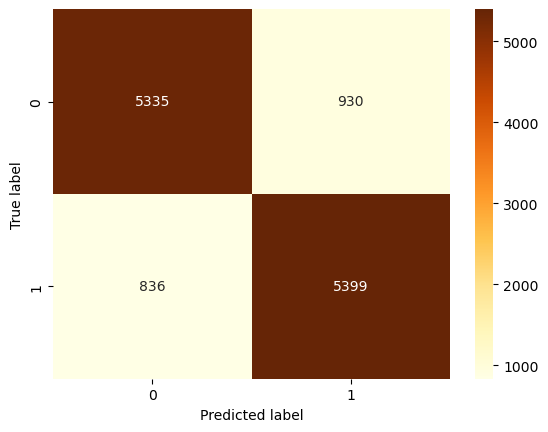

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = lr_model.predict(test_centroids)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()

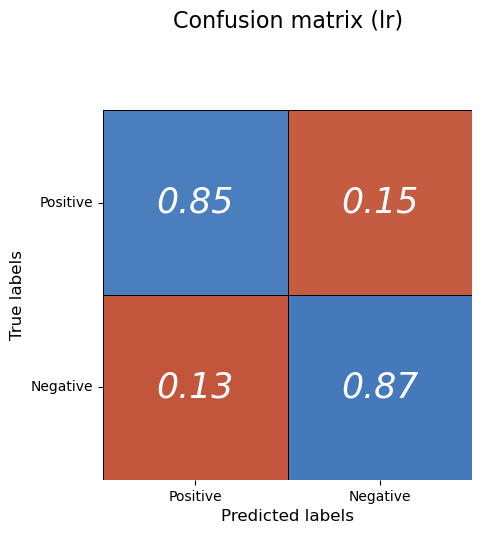

In [69]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, lr_pred, ax=axis1,
                       title='Confusion matrix (lr)')

In [70]:
svc_model = svc()

svc_model.fit(train_centroids, y_train)

LinearSVC()

In [72]:
svc_pred = svc_model.predict(test_centroids)
pred_train=svc_model.predict(train_centroids)
print("Test set Accuracy: ", accuracy_score(svc_pred, y_test)*100)
print("Training set Accuracy: ", accuracy_score(pred_train, y_train)*100)

Test set Accuracy:  86.144
Training set Accuracy:  94.072


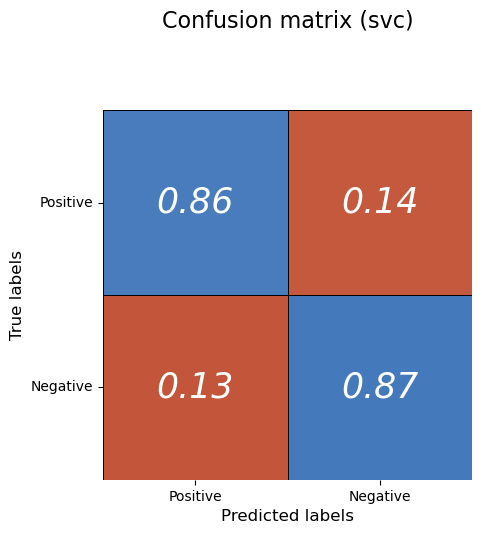

In [73]:
fig, axis1 = plt.subplots(nrows=1, ncols=1)
plot_confusion_matrix(y_test, svc_pred, ax=axis1,
                       title='Confusion matrix (svc)')

Accuracy: 0.86144
Precision: 0.8614742142623276
Recall: 0.86144
F1 Score: 0.861438559855558
Confusion Matrix:
[[5370  895]
 [ 837 5398]]


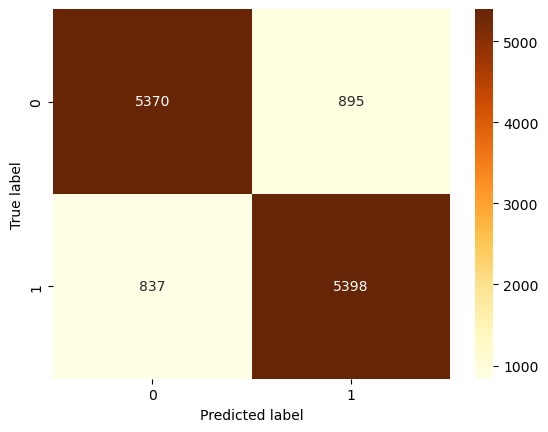

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = svc_model.predict(test_centroids)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:')
print(conf_matrix)

# Plot the confusion matrix using heatmap
sns.heatmap(conf_matrix, annot=True, cmap='YlOrBr', fmt='g', xticklabels=svc_model.classes_, yticklabels=svc_model.classes_)

plt.xlabel('Predicted label')

plt.ylabel('True label')

plt.show()